## Experiments with of a diffused censored GP in BayesNewton - Sales data

### Required imports

In [1]:
import bayesnewton
import numpy as np
import matplotlib.pyplot as plt
import time
import objax
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
import math
from tqdm import tqdm
from censored_diffused_GP import *
import pandas as pd
from sklearn.metrics import r2_score
#plt.style.use("ggplot")

np.random.seed(123)

LOG2PI = math.log(2 * math.pi)
INV2PI = (2 * math.pi) ** -1

### GP hyper-params

In [2]:
var_f = 1.0         # GP variance
len_f = 1.0         # GP lengthscale
lik_variance = 1.0  # Variance of the likelihood

### Load dataset

In [3]:
df_products = pd.read_csv('datasets/Supermarket Sales Data/annex1.csv')
df_products.head()

,Item Code,Item Name,Category Code,Category Name
0,102900005115168,Niushou Shengcai,1011010101,Flower/Leaf Vegetables
1,102900005115199,Sichuan Red Cedar,1011010101,Flower/Leaf Vegetables
2,102900005115625,Local Xiaomao Cabbage,1011010101,Flower/Leaf Vegetables
3,102900005115748,White Caitai,1011010101,Flower/Leaf Vegetables
4,102900005115762,Amaranth,1011010101,Flower/Leaf Vegetables


In [4]:
df_sales = pd.read_csv('datasets/Supermarket Sales Data/annex2.csv')
df_sales = df_sales[df_sales["Sale or Return"] == "sale"]
df_sales.head()

,Date,Time,Item Code,Quantity Sold (kilo),Unit Selling Price (RMB/kg),Sale or Return,Discount (Yes/No)
0,2020-07-01,09:15:07.924,102900005117056,0.396,7.6,sale,No
1,2020-07-01,09:17:27.295,102900005115960,0.849,3.2,sale,No
2,2020-07-01,09:17:33.905,102900005117056,0.409,7.6,sale,No
3,2020-07-01,09:19:45.450,102900005115823,0.421,10.0,sale,No
4,2020-07-01,09:20:23.686,102900005115908,0.539,8.0,sale,No


In [5]:
df_sales_grouped = df_sales.groupby(['Date','Item Code']).sum("Quantity Sold (kilo)").reset_index()
df_sales_grouped['Date'] = pd.to_datetime(df_sales_grouped['Date'])
df_sales_grouped

,Date,Item Code,Quantity Sold (kilo),Unit Selling Price (RMB/kg)
0,2020-07-01,102900005115762,6.841,66.0
1,2020-07-01,102900005115779,41.966,912.0
2,2020-07-01,102900005115786,11.352,144.0
3,2020-07-01,102900005115793,4.288,176.0
4,2020-07-01,102900005115823,11.476,280.0
...,...,...,...,...
46590,2023-06-30,102900011036686,1.000,3.9
46591,2023-06-30,102900051000463,1.376,15.6
46592,2023-06-30,102900051000944,4.339,260.0
46593,2023-06-30,106949711300259,13.000,25.2


In [6]:
idx = pd.date_range('01-07-2020', '30-06-2023')

sales_by_product = {}
for item in pd.unique(df_sales_grouped['Item Code']):
    df_temp = df_sales_grouped[df_sales_grouped["Item Code"] == item]
    df_temp = df_temp.set_index("Date").reindex(idx, fill_value=0)
    sales_by_product[item] = df_temp[["Quantity Sold (kilo)", "Unit Selling Price (RMB/kg)"]]

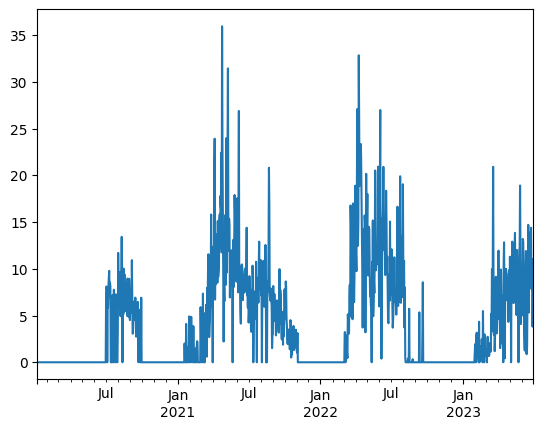

In [7]:
sales_by_product[102900005115762]["Quantity Sold (kilo)"].plot();

In [8]:
df_sales_grouped.groupby("Item Code").sum("Quantity Sold (kilo)").sort_values("Quantity Sold (kilo)", ascending=False)

,Quantity Sold (kilo),Unit Selling Price (RMB/kg)
Item Code,,
102900011016701,28181.741,515823.6
102900005116714,27555.945,582846.2
102900005116899,27166.459,312257.2
102900005115960,19196.094,32556.9
102900005115779,15915.422,327370.0
...,...,...
102900011033531,0.682,99.0
102900051000890,0.671,10.0
102900011033913,0.615,30.0


### Datasets to use

Product 1: Code=102900005116899 Name=Net Lotus Root (1)
Product 2: Code=102900011016701 Name=Wuhu Green Pepper (1)
Product 3: Code=102900005116530 Name=Xixia Mushroom (1)


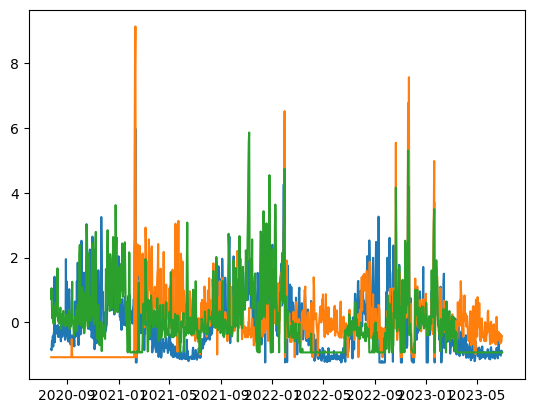

In [9]:
code1 = 102900005116899
code2 = 102900011016701
code3 = 102900005116530

def standardize_time_series(ts):
    ts_mean = ts.mean()
    ts_std = ts.std()
    ts = (ts - ts_mean) / ts_std
    return ts, ts_mean, ts_std
    
ts1 = sales_by_product[code1]["Quantity Sold (kilo)"][200:]
ts2 = sales_by_product[code2]["Quantity Sold (kilo)"][200:]
ts3 = sales_by_product[code3]["Quantity Sold (kilo)"][200:]

ts1, ts1_mean, ts1_std = standardize_time_series(ts1)
ts2, ts2_mean, ts2_std = standardize_time_series(ts2)
ts3, ts3_mean, ts3_std = standardize_time_series(ts3)

print("Product 1: Code={:d} Name={:s}".format(code1, df_products[df_products["Item Code"] == code1]["Item Name"].iloc[0]))
print("Product 2: Code={:d} Name={:s}".format(code2, df_products[df_products["Item Code"] == code2]["Item Name"].iloc[0]))
print("Product 3: Code={:d} Name={:s}".format(code3, df_products[df_products["Item Code"] == code3]["Item Name"].iloc[0]))

plt.plot(ts1)
plt.plot(ts2);
plt.plot(ts3);

### Censor time-series

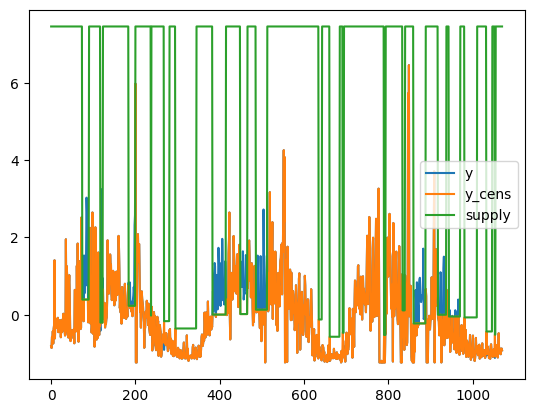

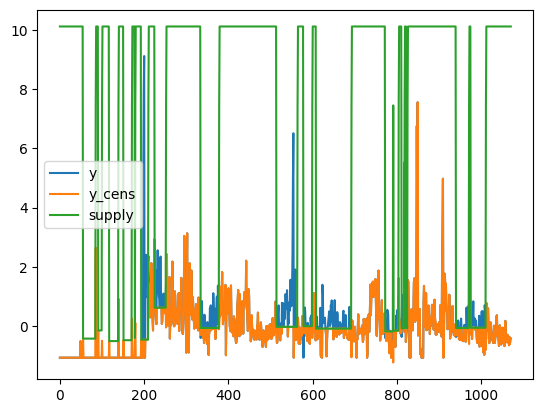

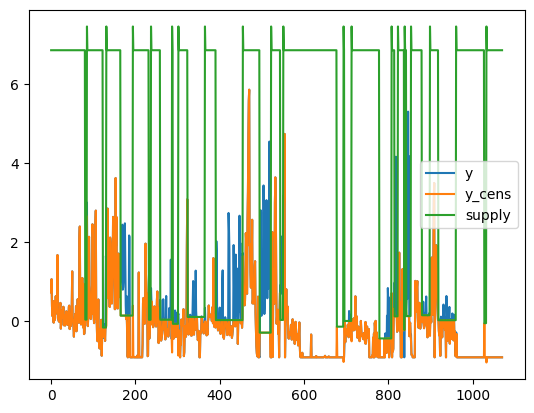

In [10]:
def censor_time_series(y, transition_prob = 0.02, recovery_prob = 0.95):
    state = 0
    supply = np.zeros(len(y))
    y_cens = np.zeros(len(y))
    for i in range(len(y)):
        if state == 0: # previously not censored
            if np.random.rand() < transition_prob:
                state = 1 # becomes censored
                supply[i] = y[i]*(np.random.rand()*0.5)
                y_cens[i] = supply[i]
            else: # continues being non-censored
                supply[i] = y.max()+1
                y_cens[i] = y[i]
        else: # previously censored
            if np.random.rand() > recovery_prob:
                state = 0 # stops being censored
                supply[i] = y1.max()+1
                y_cens[i] = y1[i]
            else: # continues being censored
                supply[i] = supply[i-1]
                y_cens[i] = min(y[i], supply[i])

    plt.plot(y, label="y")
    plt.plot(y_cens, label="y_cens")
    plt.plot(supply, label="supply")
    plt.legend()
    plt.show()
    
    return y, y_cens, supply

y1 = ts1.values
y2 = ts2.values
y3 = ts3.values

y1, y_cens1, supply1 = censor_time_series(y1)
y2, y_cens2, supply2 = censor_time_series(y2)
y3, y_cens3, supply3 = censor_time_series(y3)

In [21]:
np.sum(y1>y_cens1) / len(y1), np.sum(y2>y_cens2) / len(y2)

(0.11858076563958916, 0.18487394957983194)

### Place stations at random in 2-D space 

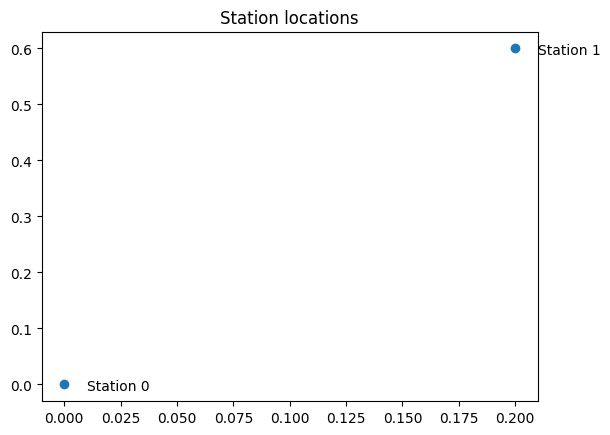

In [11]:
num_stations = 2
station_locations = np.array([[0,0], [0.2,0.6]])
station_locations

plt.scatter(station_locations[:,0], station_locations[:,1])
for i in range(num_stations):
    plt.annotate("Station %d" % (i,), station_locations[i]+np.array([0.01,-0.01]))
plt.title("Station locations")
plt.show()

station 0->1 with prob=100.0%

station 1->0 with prob=100.0%

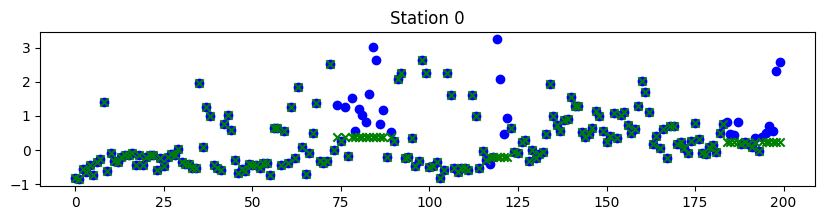

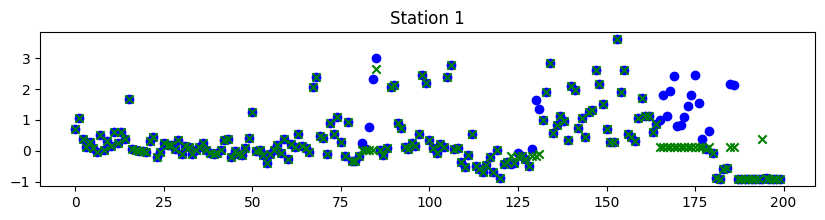

(torch.Size([2, 1071]), torch.Size([2, 1071]))

In [12]:
import torch
num_stations = 2
x = torch.arange(len(y1))
true_demands = [torch.tensor(y1).unsqueeze(0), 
                torch.tensor(y3).unsqueeze(0)]
censored_demands = [torch.tensor(y_cens1).unsqueeze(0), 
                    torch.tensor(y_cens3).unsqueeze(0)]
demand_caps = [supply1, 
                supply3]

plot_window_size = 200
for i in range(num_stations):
    true_demand = true_demands[i]
    censored_demand = censored_demands[i]
    
    plt.figure(figsize=(10,2))
    plt.scatter(x[:plot_window_size], true_demand[0,:plot_window_size], marker='o', c='blue')
    plt.scatter(x[:plot_window_size], censored_demand[0,:plot_window_size], marker='x', c='green')
    plt.title('Station %d' % (i,))
    plt.show()
    
true_demands = torch.concatenate(true_demands, dim=0)
censored_demands = torch.concatenate(censored_demands, dim=0)
true_demands.shape, censored_demands.shape

### Compute similarity matrix between stations based on RBF kernel

/Users/rodr/code/diffusion-censored-gps/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


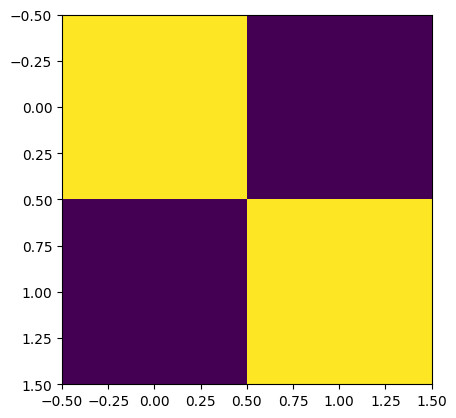

In [13]:
import pyro.contrib
kernel = pyro.contrib.gp.kernels.RBF(input_dim=2, variance=torch.tensor(1.), lengthscale=torch.tensor([.1,.1]))
similarity_matrix = kernel(torch.tensor(station_locations)).contiguous()
plt.imshow(similarity_matrix.detach().numpy())
plt.show()

### Compute transition matrix for diffusion process based on station similarity matrix above

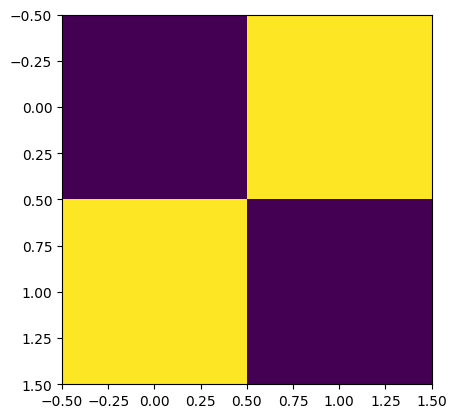

station 0->1 with prob=100.0%
station 1->0 with prob=100.0%


In [14]:
transition_matrix = torch.zeros((num_stations,num_stations))
transition_matrix = similarity_matrix - torch.eye(num_stations)
transition_matrix = transition_matrix / transition_matrix.sum(dim=1).unsqueeze(-1) # row normalize
plt.imshow(transition_matrix.detach().numpy())
plt.show()

for i in range(num_stations):
    for j in range(num_stations):
        if transition_matrix[i,j]>0.2:
            print("station %d->%d with prob=%.1f%%" % (i,j,100*transition_matrix[i,j]))

### Diffuse excess demand based on transition matrix define above for k diffusion steps

In [15]:
diffusion_steps = 1
diffused_demands = censored_demands.clone().detach()
for step in range(diffusion_steps):
    for t in range(censored_demands.shape[1]):
        excess_demand = true_demands[:,t] - diffused_demands[:,t]
        #diffused_demands[:,t] = diffused_demands[:,t] + np.dot(transition_matrix, excess_demand)
        diffused_demands[:,t] = diffused_demands[:,t] + torch.mm(excess_demand.unsqueeze(0), transition_matrix)
    
diffused_demands.shape

torch.Size([2, 1071])

In [16]:
# throw away excess demand remaining after diffusion
diffused_demands = torch.minimum(diffused_demands, torch.tensor(demand_caps))
diffused_demands.shape

/var/folders/bw/h1kxbkp13n3bk380h6tmspd00000gp/T/ipykernel_47304/1887764844.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  diffused_demands = torch.minimum(diffused_demands, torch.tensor(demand_caps))


torch.Size([2, 1071])

### Plot observed demand data after diffusion process over the excess demand

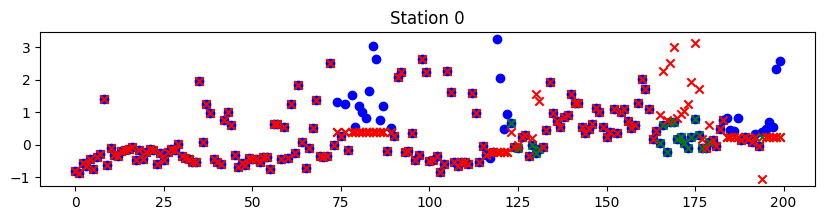

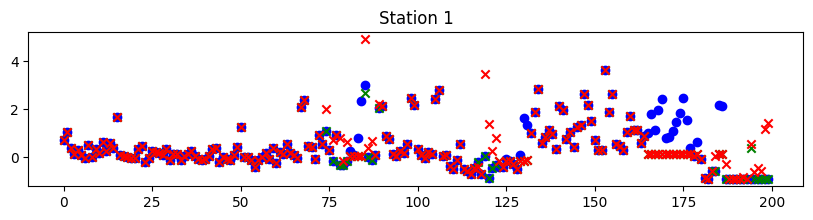

In [17]:
plot_window_size = 200
for i in range(num_stations):
    plt.figure(figsize=(10,2))
    plt.scatter(x[:plot_window_size], true_demands[i,:plot_window_size], marker='o', c='blue')
    #plt.plot(x, stations_demand_cap[i]*np.ones(len(x)), c='red')
    plt.scatter(x[:plot_window_size], censored_demands[i,:plot_window_size], marker='x', c='green')
    plt.scatter(x[:plot_window_size], diffused_demands[i,:plot_window_size].detach().cpu(), marker='x', c='red')
    plt.title('Station %d' % (i,))
    plt.show()

In [18]:
train_perc = 0.9    # Percentage of data used for training
N_test = int((1-train_perc)*true_demands.shape[1])
print("N_test:", N_test)
perm = np.random.permutation(true_demands.shape[1])
ix_train = sorted(perm[:-N_test].copy())
ix_test = sorted(perm[-N_test:].copy())

x_all = np.linspace(0,1,true_demands.shape[1])

N = true_demands.shape[1] - N_test
print("N:", N)
x = x_all[ix_train]
print("\nx:", x.shape)
y = true_demands.T.numpy()[ix_train,:,None]
print("y:", y.shape)
y_cens = censored_demands.T.numpy()[ix_train,:,None]
print("y_cens:", y_cens.shape)
y_diffused = diffused_demands.T.detach().numpy()[ix_train,:,None]
print("y_diffused:", y_diffused.shape)
censoring_thre = np.array(demand_caps).T[ix_train,:,None]
print("censoring_thre:", censoring_thre.shape)
censoring_indicator = y > censoring_thre
print("censoring_indicator:", censoring_indicator.shape)

x_test = x_all[ix_test]
print("\nx_test:", x_test.shape)
y_test = true_demands.T.numpy()[ix_test,:,None]
print("y_test:", y_test.shape)
y_cens_test = censored_demands.T.numpy()[ix_test,:,None]
print("y_cens_test:", y_cens_test.shape)
y_diffused_test = diffused_demands.T.detach().numpy()[ix_test,:,None]
print("y_diffused_test:", y_diffused_test.shape)
censoring_thre_test = np.array(demand_caps).T[ix_test,:,None]
print("censoring_thre_test:", censoring_thre_test.shape)
censoring_indicator_test = y_test > censoring_thre_test
print("censoring_indicator_test:", censoring_indicator_test.shape)

N_test: 107
N: 964

x: (964,)
y: (964, 2, 1)
y_cens: (964, 2, 1)
y_diffused: (964, 2, 1)
censoring_thre: (964, 2, 1)
censoring_indicator: (964, 2, 1)

x_test: (107,)
y_test: (107, 2, 1)
y_cens_test: (107, 2, 1)
y_diffused_test: (107, 2, 1)
censoring_thre_test: (107, 2, 1)
censoring_indicator_test: (107, 2, 1)


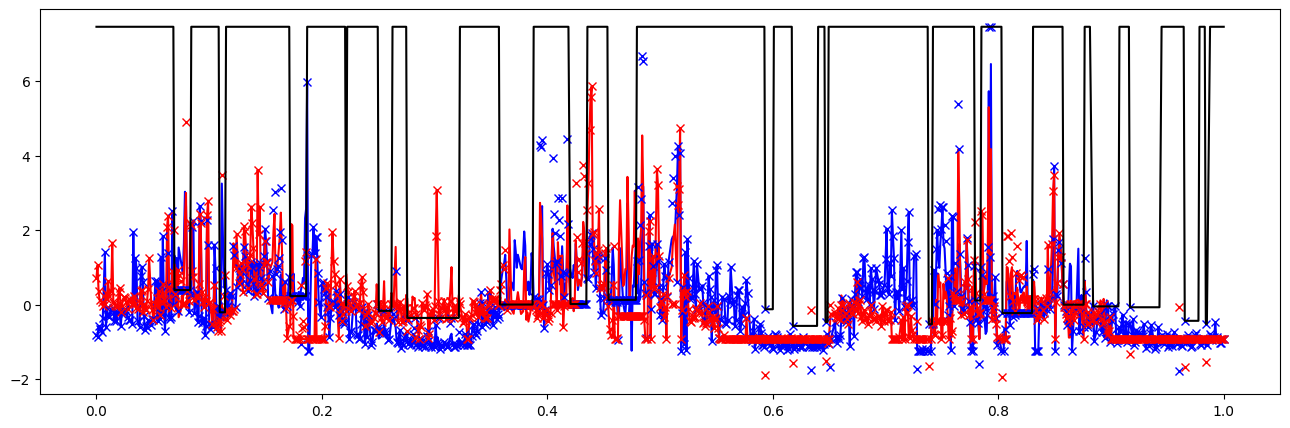

In [19]:
plt.figure(1, figsize=(16, 5))
#plt.plot(x, f1, 'b-')
#plt.plot(x, f2, 'r-')
plt.plot(x, y[:, 0], 'b-')
plt.plot(x, y[:, 1], 'r-')
#plt.plot(x, y_cens[:, 0], 'bx')
#plt.plot(x, y_cens[:, 1], 'rx')
plt.plot(x, y_diffused[:, 0], 'bx')
plt.plot(x, y_diffused[:, 1], 'rx')
plt.plot(x, censoring_thre[:,0], 'k-')

In [20]:
X_diffusion = jnp.array([[-1,-1],
                         [1,1]])

print("----------------------- Regularized Laplacian kernel:")
print(k_RL(X_diffusion, lengthscale=10, beta=1))

print("----------------------- Diffusion kernel:")
print(k_Diff(X_diffusion, lengthscale=10, beta=1))

print("----------------------- My diffusion kernel:")
print(compute_transition_matrix(X_diffusion, diffusion_lengthscale=10))

----------------------- Regularized Laplacian kernel:
W: [[1.         0.92311635]
 [0.92311635 1.        ]]
Lap: [[ 0.92311635 -0.92311635]
 [-0.92311635  0.92311635]]
[[0.67567081 0.32432919]
 [0.32432919 0.67567081]]
----------------------- Diffusion kernel:
W: [[1.         0.92311635]
 [0.92311635 1.        ]]
Lap: [[ 0.92311635 -0.92311635]
 [-0.92311635  0.92311635]]
[[0.39727905 2.51712241]
 [2.51712241 0.39727905]]
----------------------- My diffusion kernel:
[[0. 1.]
 [1. 0.]]


censoring_threshold: (964, 2) 
 [[7.45674254 6.85511021]
 [7.45674254 6.85511021]
 [7.45674254 6.85511021]
 [7.45674254 6.85511021]
 [7.45674254 6.85511021]]
f: (964, 2) 
 [[-0.81839646  0.72140063]
 [-0.8603525   1.05347251]
 [-0.57268188  0.37271232]
 [-0.65189411  0.11995397]
 [-0.74598923  0.07687114]]
excess_demand: (964, 2) 
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
diffused_f: (964, 2) 
 [[-0.81839646  0.72140063]
 [-0.8603525   1.05347251]
 [-0.57268188  0.37271232]
 [-0.65189411  0.11995397]
 [-0.74598923  0.07687114]]


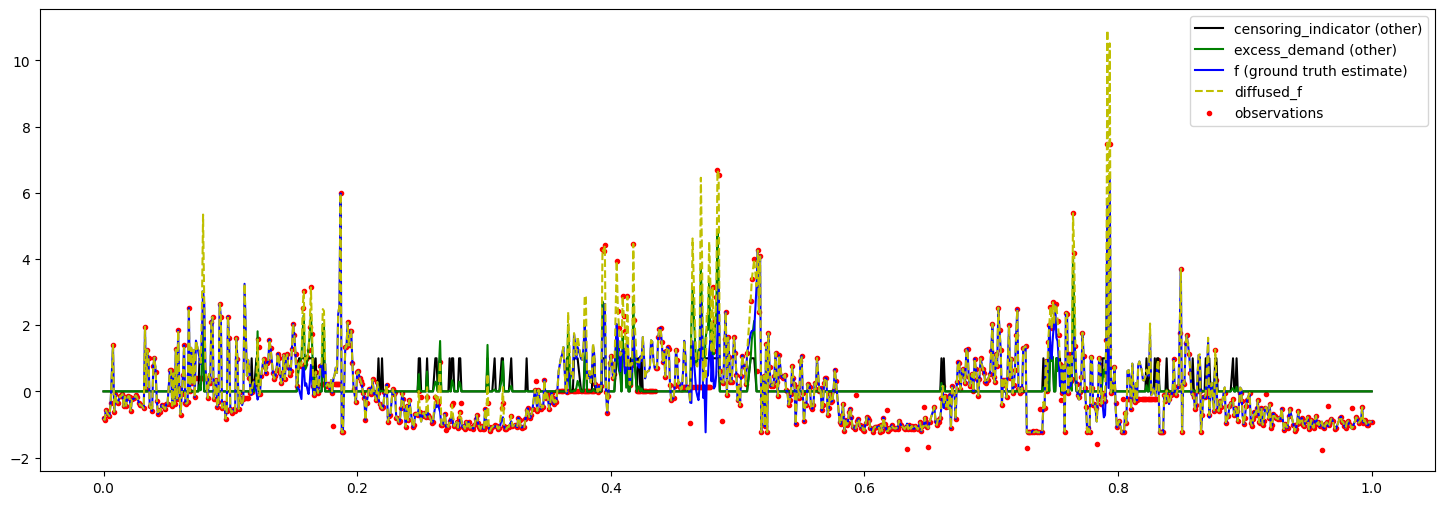

In [21]:
### Testing out the diffusion process to see if it is working

transition_matrix = compute_transition_matrix(X_diffusion, diffusion_lengthscale=10)

### Diffuse excess demand based on transition matrix define above for k diffusion steps
censoring_threshold = censoring_thre[:,:,0]
print("censoring_threshold:", censoring_threshold.shape, '\n', censoring_threshold[:5])
f = y[:,:,0] ## assume perfect estimate for f
print("f:", f.shape, '\n', f[:5])
excess_demand = jnp.maximum(f - censoring_threshold, jnp.zeros(f.shape))
print("excess_demand:", excess_demand.shape, '\n', excess_demand[:5])
diffused_f = f + excess_demand @ transition_matrix
print("diffused_f:", diffused_f.shape, '\n', diffused_f[:5])
plt.figure(figsize=(18,6))
plt.plot(x, censoring_indicator[:,1], 'k-')
plt.plot(x, excess_demand[:,1], 'g-')
plt.plot(x, f[:,0], 'b-')
plt.plot(x, diffused_f[:,0], 'y--')
plt.scatter(x, y_diffused[:,0,0], marker='.', c='r')
plt.legend(["censoring_indicator (other)", 
            "excess_demand (other)", 
            "f (ground truth estimate)", 
            "diffused_f",
            "observations"])
plt.show()

### Re-usable code blocks for training and evaluating models

In [22]:
def train_model(kern, lik, x, y, iters=500, lr_adam = 0.1, lr_newton = 1.):
    # model = bayesnewton.models.MarkovNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # model = bayesnewton.models.MarkovExpectationPropagationGP(kernel=kern, likelihood=lik, X=x, Y=y, power=0.5)
    # -- Gauss-Newton ---
    # model = bayesnewton.models.MarkovGaussNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # model = bayesnewton.models.MarkovVariationalGaussNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # -- quasi-Newton ---
    # model = bayesnewton.models.MarkovQuasiNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # model = bayesnewton.models.MarkovVariationalQuasiNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # model = bayesnewton.models.MarkovExpectationPropagationQuasiNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y, power=0.5)
    # --- Riemannian grads ---
    # model = bayesnewton.models.MarkovVariationalRiemannGP(kernel=kern, likelihood=lik, X=x, Y=y)

    
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E


    train_op = objax.Jit(train_op)

    t0 = time.time()
    loop = tqdm(range(iters))
    losses = []
    for i in loop:
        loss = train_op()
        #if not i % 20:
        #    print('iter %2d, energy: %1.4f' % (i, loss[0]))
        loop.set_description(f"Iter [{i}/{iters}]")
        loop.set_postfix(loss=loss[0])
        losses.append(loss[0])
    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    
    plt.figure(1, figsize=(6, 4))
    plt.plot(losses, label='training loss')
    plt.title("Training loss")
    plt.show()
    
    return model
    

def eval_model(model, x, y, y_diffused, x_test, y_test):
    t0 = time.time()
    # evaluate on train set 
    posterior_mean_train, posterior_cov_train = model.predict_y(X=x)
    nlpd_train_diff = model.negative_log_predictive_density(X=x, Y=y_diffused)
    nlpd_train = model.negative_log_predictive_density(X=x, Y=y)
    rmse_train = np.sqrt(np.mean((y[:,:posterior_mean_train.shape[1],0] - posterior_mean_train)**2))
    r2_train = r2_score(y[:,:posterior_mean_train.shape[1],0], np.array(posterior_mean_train)) 
    print('[trainset] nlpd (diffused): %2.3f\tnlpd (true): %2.3f\trmse (true): %2.3f\tr2 (true): %2.3f' % (nlpd_train_diff, nlpd_train, rmse_train, r2_train))

    # evaluate on test set 
    posterior_mean_test, posterior_cov_test = model.predict_y(X=x_test)
    nlpd_test = model.negative_log_predictive_density(X=x_test, Y=y_test)
    rmse_test = np.sqrt(np.mean((y_test[:,:posterior_mean_test.shape[1],0] - posterior_mean_test)**2))
    r2_test = r2_score(y_test[:,:posterior_mean_test.shape[1],0], np.array(posterior_mean_test))
    print('[testset] \t\t\t\tnlpd (true): %2.3f\trmse (true): %2.3f\tr2 (true): %2.3f' % (nlpd_test, rmse_test, r2_test))
    t1 = time.time()
    print('prediction time: %2.2f secs' % (t1-t0))

    # make plots with predictions
    posterior_mean, posterior_cov = model.predict_y(X=x)
    posterior_var = bayesnewton.utils.diag(posterior_cov)
    lb = posterior_mean - 1.96 * posterior_var ** 0.5
    ub = posterior_mean + 1.96 * posterior_var ** 0.5

    print('plotting ...')
    plt.figure(1, figsize=(16, 5))
    plt.clf()
    plt.plot(x, y_diffused[:, 0], 'bx', label='y_diffused')
    # plt.plot(x_test, y_test, 'r.', alpha=0.4, label='test observations')
    plt.plot(x, posterior_mean[:, 0], 'b')
    plt.plot(x, y[:,0], 'b--')
    plt.fill_between(x, lb[:, 0], ub[:, 0], color='b', alpha=0.05)
    plt.xlim([x[0], x[-1]])
    if hasattr(model, 'Z'):
        plt.plot(model.Z.value[:, 0], -2 * np.ones_like(model.Z.value[:, 0]), 'b^', markersize=5)
    plt.legend()
    plt.title('Time-series 1')
    plt.xlabel('$X$')
    plt.show()
    
    plt.figure(2, figsize=(16, 5))
    plt.clf()
    plt.plot(x, y_diffused[:, 1], 'rx', label='y_diffused')
    # plt.plot(x_test, y_test, 'r.', alpha=0.4, label='test observations')
    plt.plot(x, posterior_mean[:, 1], 'r')
    plt.plot(x, y[:,1], 'r--')
    plt.fill_between(x, lb[:, 1], ub[:, 1], color='r', alpha=0.05)
    plt.xlim([x[0], x[-1]])
    if hasattr(model, 'Z'):
        plt.plot(model.Z.value[:, 0], -2 * np.ones_like(model.Z.value[:, 0]), 'b^', markersize=5)
    plt.legend()
    plt.title('Time-series 2')
    plt.xlabel('$X$')
    plt.show()

### Fit Gaussian GP to true data

Iter [499/500]: 100%|██████████| 500/500 [00:13<00:00, 37.23it/s, loss=2193.7089309480034]


optimisation time: 13.45 secs


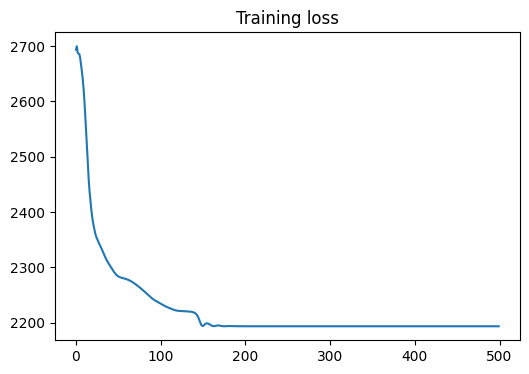

In [23]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2])
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyGaussianMulti(ndim=2, variance=lik_variance*jnp.ones(2))
#lik = bayesnewton.likelihoods.Gaussian(variance=1)

model = train_model(kern, lik, x, y)

[trainset] nlpd (diffused): 2.181	nlpd (true): 1.541	rmse (true): 0.527	r2 (true): 0.726
[testset] 				nlpd (true): 1.692	rmse (true): 0.551	r2 (true): 0.627
prediction time: 5.15 secs
plotting ...


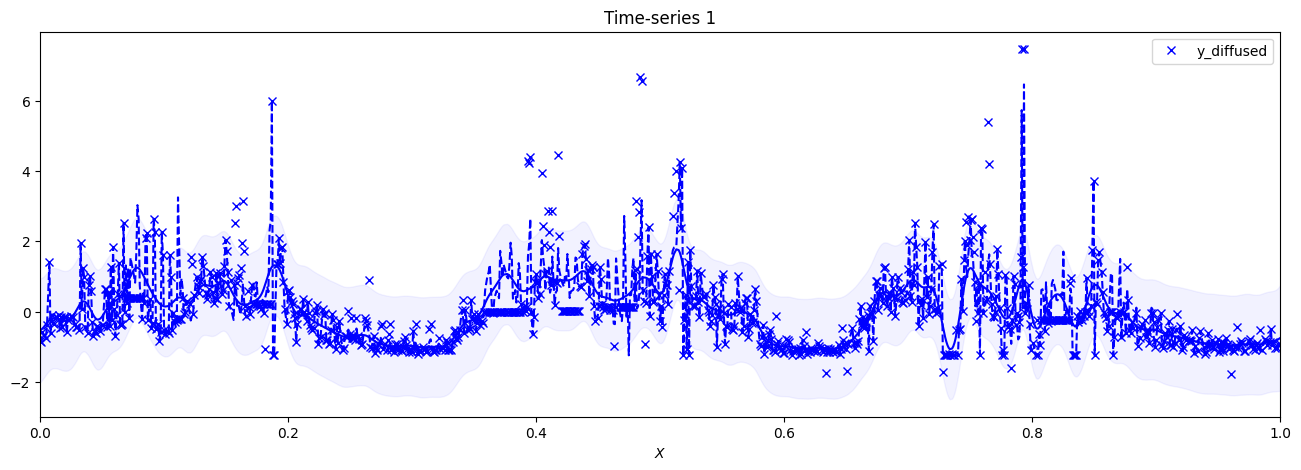

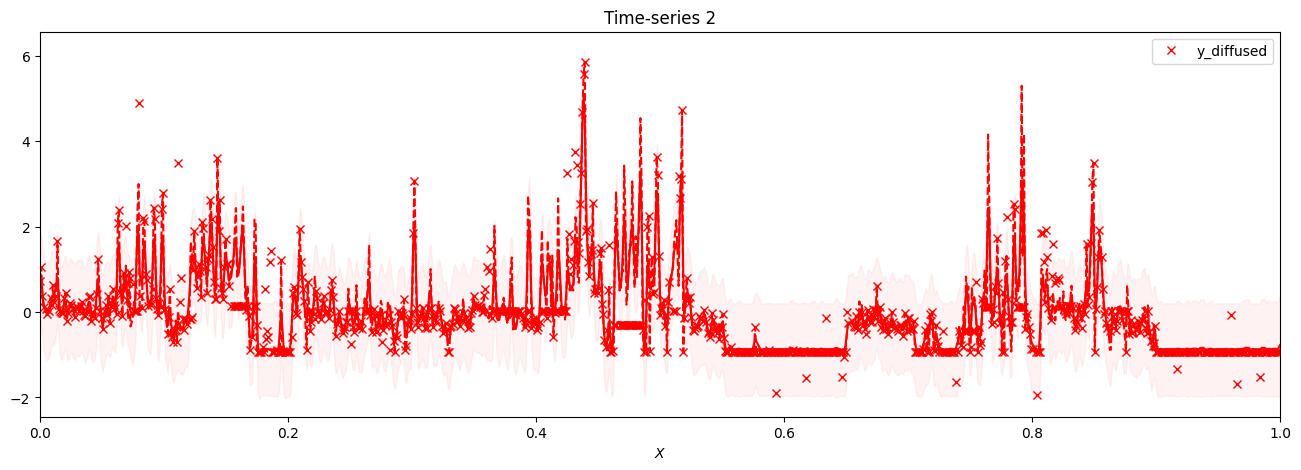

In [24]:
eval_model(model, x, y, y_diffused, x_test, y_test)

### Fit Gaussian GP to diffused data

Iter [499/500]: 100%|██████████| 500/500 [00:13<00:00, 36.90it/s, loss=2224.781188337936] 


optimisation time: 13.55 secs


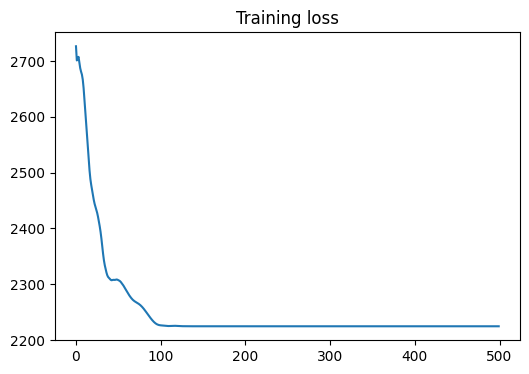

In [25]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2])
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyGaussianMulti(ndim=2, variance=lik_variance*jnp.ones(2))
#lik = bayesnewton.likelihoods.Gaussian(variance=1)

model = train_model(kern, lik, x, y_diffused)

[trainset] nlpd (diffused): 1.943	nlpd (true): 2.285	rmse (true): 0.735	r2 (true): 0.469
[testset] 				nlpd (true): 2.066	rmse (true): 0.669	r2 (true): 0.446
prediction time: 2.31 secs
plotting ...


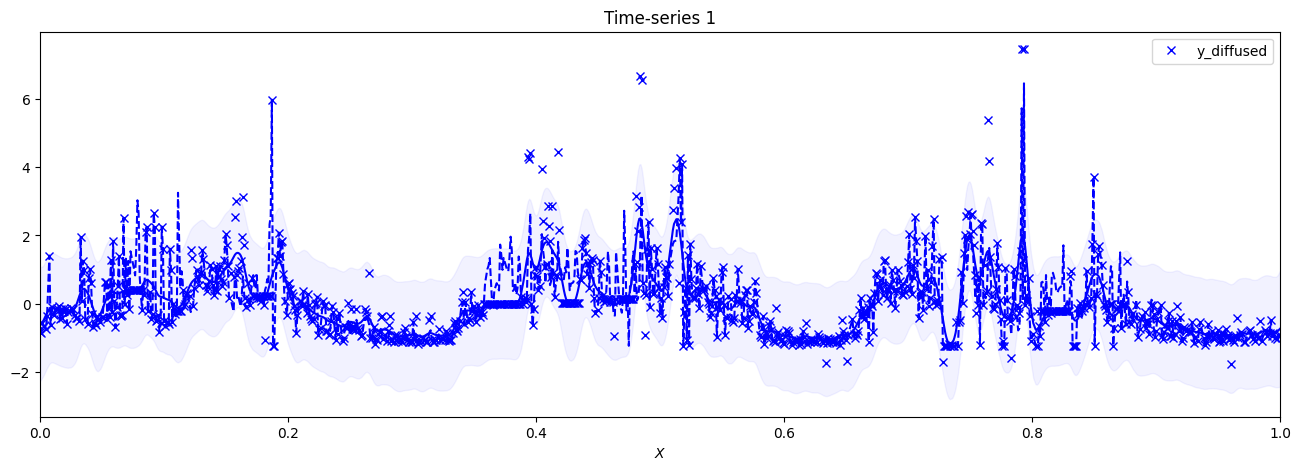

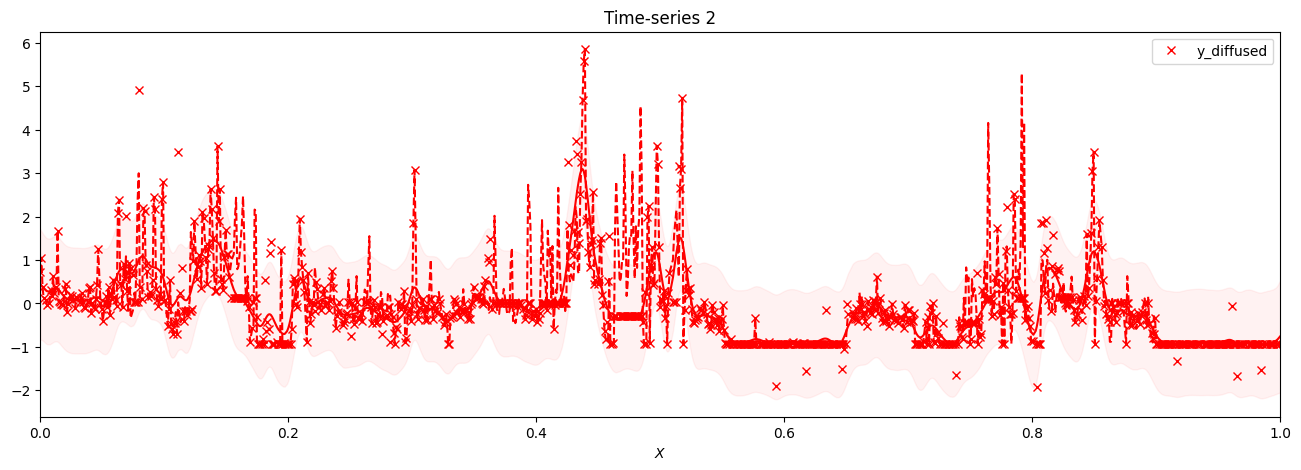

In [26]:
eval_model(model, x, y, y_diffused, x_test, y_test)

### Fit Censored Gaussian GP to diffused data

Iter [499/500]: 100%|██████████| 500/500 [00:21<00:00, 23.42it/s, loss=2091.8094452823407]


optimisation time: 21.35 secs


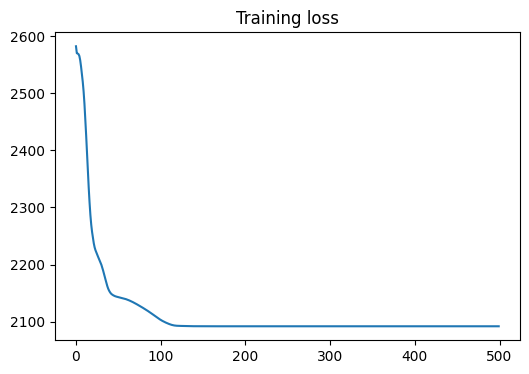

In [27]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2])
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyCensoredGaussianMulti(ndim=2, variance=lik_variance*jnp.ones(2))
#lik = bayesnewton.likelihoods.Gaussian(variance=1)

model = train_model(kern, lik, x, np.concatenate([y_diffused, censoring_thre], axis=1))

[trainset] nlpd (diffused): 1.853	nlpd (true): 2.166	rmse (true): 0.714	r2 (true): 0.499
[testset] 				nlpd (true): 2.010	rmse (true): 0.653	r2 (true): 0.472
prediction time: 2.86 secs
plotting ...


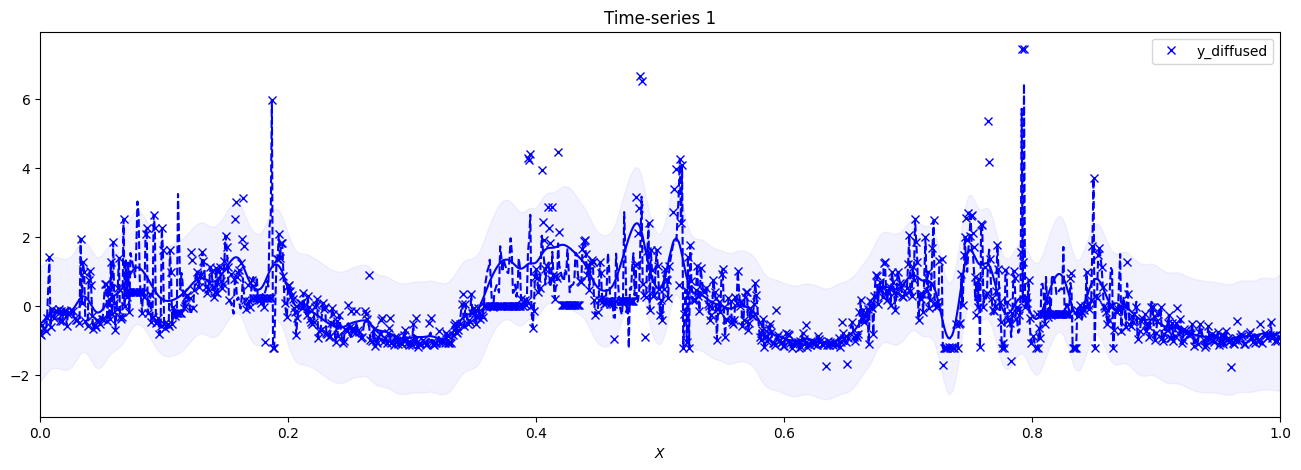

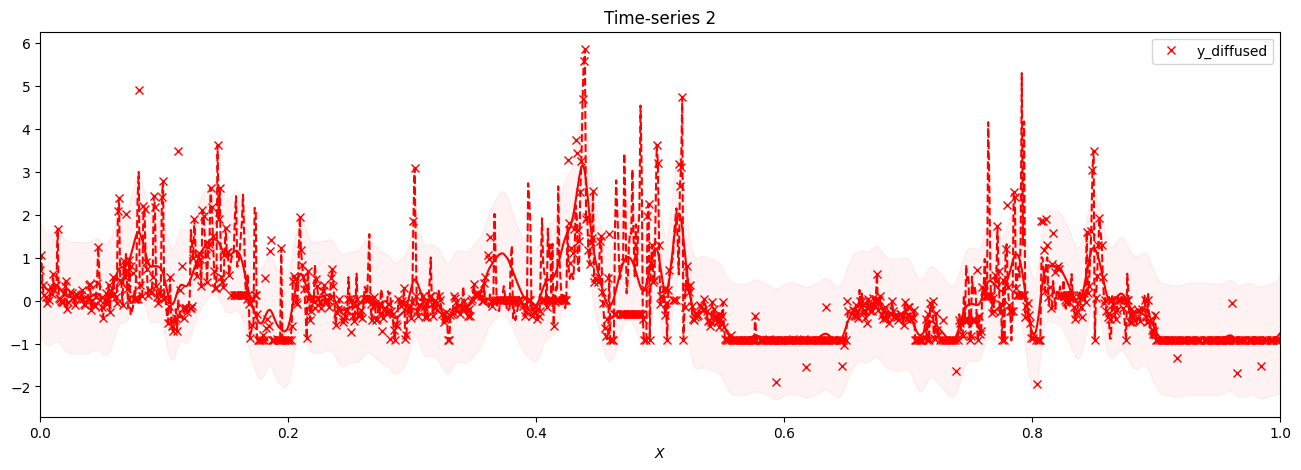

In [28]:
eval_model(model, 
           x, np.concatenate([y, censoring_thre], axis=1), np.concatenate([y_diffused, censoring_thre], axis=1),
           x_test, np.concatenate([y_test, censoring_thre_test], axis=1))

### Fit Diffused Censored Gaussian GP to diffused data - D

Iter [1999/2000]: 100%|██████████| 2000/2000 [02:09<00:00, 15.46it/s, loss=2015.0140604622154]


optimisation time: 129.35 secs


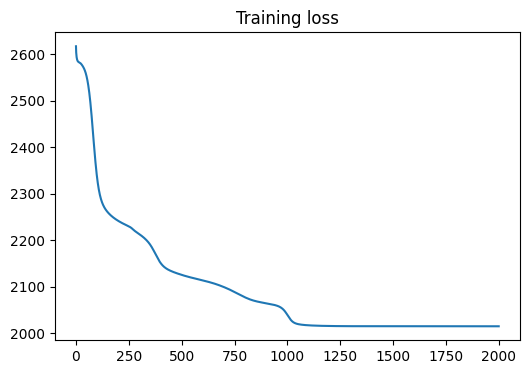

In [23]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2])
#lik = bayesnewton.likelihoods.Gaussian(variance=1)
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyDiffusedCensoredGaussianMultiD(X_diffusion, 
                                      ndim=2, 
                                      variance=lik_variance*jnp.ones(2),
                                      diffusion_lengthscale=1.,
                                      diffusion_variance=1.,
                                      fix_diffusion=True,
                                      fix_variance=False)

#model = train_model(kern, lik, x, np.concatenate([y_diffused, censoring_thre], axis=1), iters=1000)
model = train_model(kern, lik, x, np.concatenate([y_diffused, censoring_thre], axis=1), iters=2000, lr_newton=0.1, lr_adam=0.01) # MUCH BETTER THIS WAY

[trainset] nlpd (diffused): 1.313	nlpd (true): 1.740	rmse (true): 0.591	r2 (true): 0.657
[testset] 				nlpd (true): 1.968	rmse (true): 0.602	r2 (true): 0.553
prediction time: 5.51 secs
plotting ...


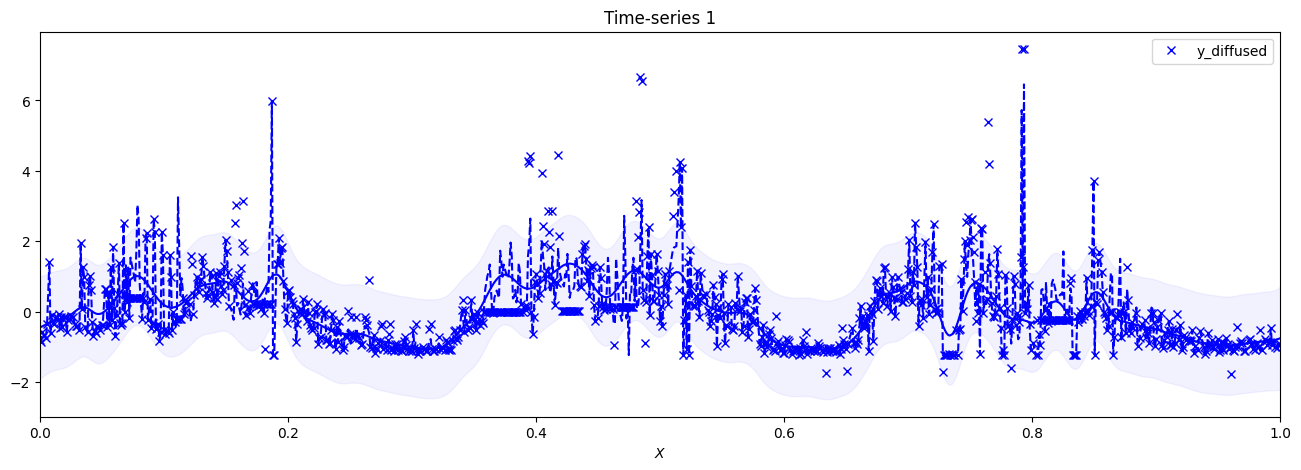

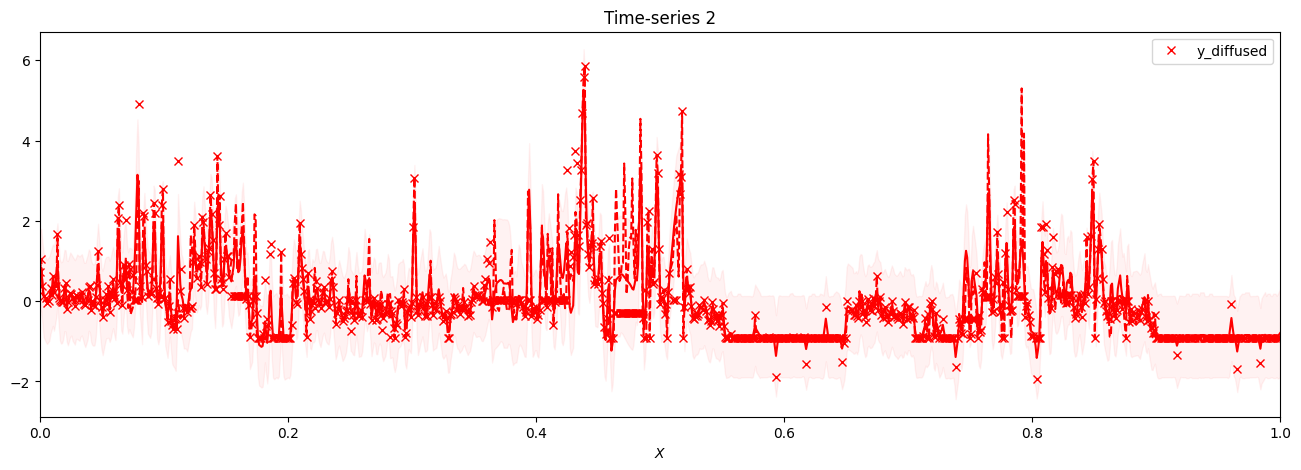

In [24]:
eval_model(model, 
           x, np.concatenate([y, censoring_thre], axis=1), np.concatenate([y_diffused, censoring_thre], axis=1),
           x_test, np.concatenate([y_test, censoring_thre_test], axis=1))

Iter [1999/2000]: 100%|██████████| 2000/2000 [01:55<00:00, 17.38it/s, loss=1994.98641947384]  


optimisation time: 115.07 secs


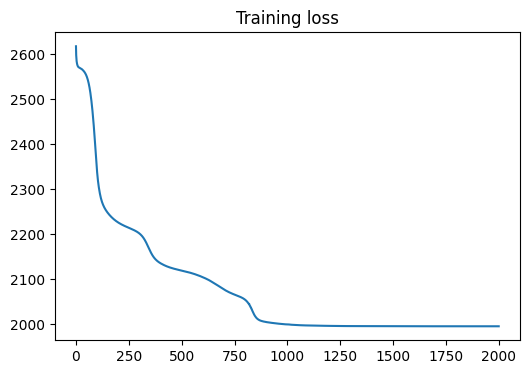

In [27]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2])
#lik = bayesnewton.likelihoods.Gaussian(variance=1)
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyDiffusedCensoredGaussianMultiD(X_diffusion, 
                                      ndim=2, 
                                      variance=lik_variance*jnp.ones(2),
                                      diffusion_lengthscale=1.,
                                      diffusion_variance=1.,
                                      fix_diffusion=False,
                                      fix_variance=False)

#model = train_model(kern, lik, x, np.concatenate([y_diffused, censoring_thre], axis=1), iters=1000)
model = train_model(kern, lik, x, np.concatenate([y_diffused, censoring_thre], axis=1), iters=2000, lr_newton=0.1, lr_adam=0.01) # MUCH BETTER THIS WAY

[trainset] nlpd (diffused): 1.328	nlpd (true): 1.896	rmse (true): 0.612	r2 (true): 0.632
[testset] 				nlpd (true): 2.103	rmse (true): 0.601	r2 (true): 0.554
prediction time: 1.88 secs
plotting ...


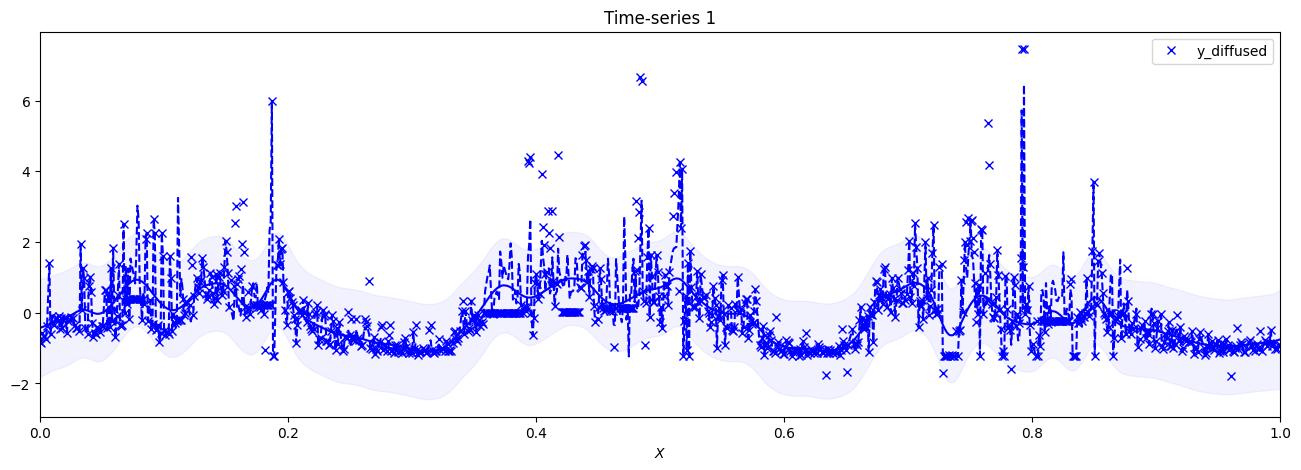

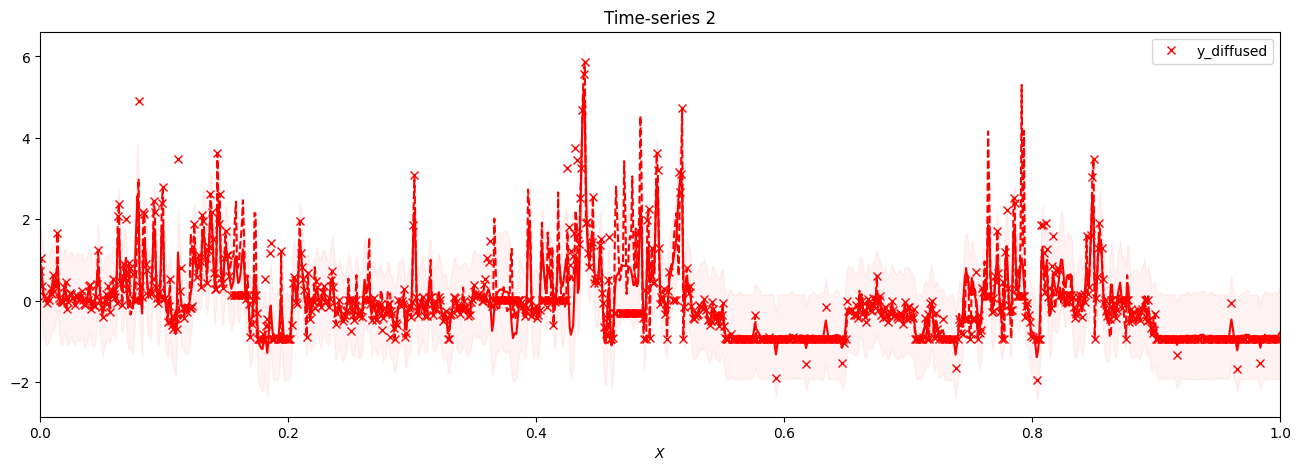

In [28]:
eval_model(model, 
           x, np.concatenate([y, censoring_thre], axis=1), np.concatenate([y_diffused, censoring_thre], axis=1),
           x_test, np.concatenate([y_test, censoring_thre_test], axis=1))